In [1]:
%config IPCompleter.use_jedi = False
%pdb off
# %load_ext viztracer
# from viztracer import VizTracer
%load_ext autoreload
%autoreload 3
import sys
from pathlib import Path
import neptune # for logging progress and results
from pyphoplacecellanalysis.General.Batch.NeptuneAiHelpers import set_environment_variables, neptune_output_figures
neptune_kwargs = {'project':"commander.pho/PhoDibaLongShort2023",
'api_token':"eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxOGIxODU2My1lZTNhLTQ2ZWMtOTkzNS02ZTRmNzM5YmNjNjIifQ=="}

# required to enable non-blocking interaction:
%gui qt5

from copy import deepcopy
from numba import jit
import numpy as np
import pandas as pd
from attrs import define, field, fields, Factory

# Pho's Formatting Preferences
# from pyphocorehelpers.preferences_helpers import set_pho_preferences, set_pho_preferences_concise, set_pho_preferences_verbose
# set_pho_preferences_concise()

## Pho's Custom Libraries:
from pyphocorehelpers.general_helpers import CodeConversion
from pyphocorehelpers.function_helpers import function_attributes
from pyphocorehelpers.print_helpers import print_keys_if_possible, print_value_overview_only, document_active_variables, objsize, print_object_memory_usage, debug_dump_object_member_shapes, TypePrintMode
from pyphocorehelpers.print_helpers import get_now_day_str, get_now_time_str, get_now_time_precise_str
from pyphocorehelpers.programming_helpers import IPythonHelpers
from pyphocorehelpers.Filesystem.path_helpers import find_first_extant_path
from pyphocorehelpers.Filesystem.open_in_system_file_manager import reveal_in_system_file_manager

# NeuroPy (Diba Lab Python Repo) Loading
# from neuropy import core
from neuropy.analyses.placefields import PlacefieldComputationParameters
from neuropy.core.epoch import NamedTimerange, Epoch
from neuropy.core.ratemap import Ratemap
from neuropy.core.session.Formats.BaseDataSessionFormats import DataSessionFormatRegistryHolder
from neuropy.core.session.Formats.Specific.BapunDataSessionFormat import BapunDataSessionFormatRegisteredClass
from neuropy.core.session.Formats.Specific.KDibaOldDataSessionFormat import KDibaOldDataSessionFormatRegisteredClass
from neuropy.core.session.Formats.Specific.RachelDataSessionFormat import RachelDataSessionFormat
from neuropy.core.session.Formats.Specific.HiroDataSessionFormat import HiroDataSessionFormatRegisteredClass

## For computation parameters:
from neuropy.analyses.placefields import PlacefieldComputationParameters
from neuropy.utils.dynamic_container import DynamicContainer
from neuropy.utils.result_context import IdentifyingContext
from neuropy.core.session.Formats.BaseDataSessionFormats import find_local_session_paths
from neuropy.core.neurons import NeuronType

from pyphocorehelpers.print_helpers import generate_html_string

# pyPhoPlaceCellAnalysis:
from pyphoplacecellanalysis.General.Pipeline.NeuropyPipeline import NeuropyPipeline # get_neuron_identities
from pyphoplacecellanalysis.General.Mixins.ExportHelpers import export_pyqtgraph_plot, create_daily_programmatic_display_function_testing_folder_if_needed, session_context_to_relative_path
from pyphoplacecellanalysis.General.Batch.NonInteractiveProcessing import batch_load_session, batch_extended_computations, SessionBatchProgress, batch_programmatic_figures, batch_extended_programmatic_figures
from pyphoplacecellanalysis.General.Pipeline.NeuropyPipeline import PipelineSavingScheme
from pyphoplacecellanalysis.Pho2D.matplotlib.visualize_heatmap import visualize_heatmap
from pyphoplacecellanalysis.Pho2D.PyQtPlots.Extensions.pyqtgraph_helpers import build_pyqtgraph_epoch_indicator_regions # Add session indicators to pyqtgraph plot
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.MultiContextComparingDisplayFunctions.LongShortTrackComparingDisplayFunctions import _helper_add_long_short_session_indicator_regions
import pyphoplacecellanalysis.External.pyqtgraph as pg

from pyphoplacecellanalysis.General.Batch.NonInteractiveProcessing import batch_perform_all_plots
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.LongShortTrackComputations import JonathanFiringRateAnalysisResult
from pyphoplacecellanalysis.General.Mixins.CrossComputationComparisonHelpers import _find_any_context_neurons

# Plotting
import pylustrator
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.SpikeRasters import plot_multiple_raster_plot, plot_raster_plot
from pyphoplacecellanalysis.General.Mixins.DataSeriesColorHelpers import DataSeriesColorHelpers
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.helpers import _helper_make_scatterplot_clickable
from pyphoplacecellanalysis.General.Mixins.DataSeriesColorHelpers import UnitColoringMode, DataSeriesColorHelpers
from scripts.run_BatchAnalysis import post_compute_validate, _on_complete_success_execution_session
from PendingNotebookCode import PAPER_FIGURE_figure_1_add_replay_epoch_rasters, PAPER_FIGURE_figure_1_full
from PendingNotebookCode import PAPER_FIGURE_figure_3

session_batch_status = {}
session_batch_errors = {}
enable_saving_to_disk = False

global_data_root_parent_path = find_first_extant_path([Path(r'W:\Data'), Path(r'/media/MAX/Data'), Path(r'/Volumes/MoverNew/data'), Path(r'/home/halechr/turbo/Data')])
assert global_data_root_parent_path.exists(), f"global_data_root_parent_path: {global_data_root_parent_path} does not exist! Is the right computer's config commented out above?"

Automatic pdb calling has been turned OFF
build_module_logger(module_name="Spike3D.pipeline"):
	 Module logger com.PhoHale.Spike3D.pipeline has file logging enabled and will log to EXTERNAL\TESTING\Logging\debug_com.PhoHale.Spike3D.pipeline.log


# Load Pipeline

In [2]:
%pdb off
# ==================================================================================================================== #
# Load Data                                                                                                            #
# ==================================================================================================================== #

active_data_mode_name = 'kdiba'

## Data must be pre-processed using the MATLAB script located here: 
#     neuropy/data_session_pre_processing_scripts/KDIBA/IIDataMat_Export_ToPython_2022_08_01.m
# From pre-computed .mat files:

local_session_root_parent_context = IdentifyingContext(format_name=active_data_mode_name) # , animal_name='', configuration_name='one', session_name=self.session_name
local_session_root_parent_path = global_data_root_parent_path.joinpath('KDIBA')

# [*] - indicates bad or session with a problem
# 0, 1, 2, 3, 4, 5, 6, 7, [8], [9], 10, 11, [12], 13, 14, [15], [16], 17, 
# curr_context: IdentifyingContext = good_contexts_list[1] # select the session from all of the good sessions here.
curr_context = IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='one',session_name='2006-6-08_14-26-15') # DONE. Very good. Many good Pfs, many good replays.
# curr_context = IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='one',session_name='2006-6-09_1-22-43') # BAD
# curr_context = IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='one',session_name='2006-6-12_15-55-31') # DONE, Good Pfs but no good replays
# curr_context = IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='one',session_name='2006-6-13_14-42-6') # BAD
# curr_context = IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='two',session_name='2006-6-07_16-40-19') # DONE, GREAT, both good Pfs and replays!
# curr_context = IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='two',session_name='2006-6-08_21-16-25') # DONE
# curr_context = IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='two',session_name='2006-6-09_22-24-40') # DONE
# curr_context = IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='two',session_name='2006-6-12_16-53-46') # DONE
# curr_context = IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='two',session_name='2006-6-13_15-22-3') # DONE, Good Pfs, no good epochs.
# curr_context = IdentifyingContext(format_name='kdiba',animal='vvp01',exper_name='one',session_name='2006-4-09_17-29-30') # DONE
# curr_context = IdentifyingContext(format_name='kdiba',animal='vvp01',exper_name='one',session_name='2006-4-10_12-25-50') # DONE
# curr_context = IdentifyingContext(format_name='kdiba',animal='vvp01',exper_name='one',session_name='2006-4-19_13-34-40') # BAD
# curr_context = IdentifyingContext(format_name='kdiba',animal='vvp01',exper_name='two',session_name='2006-4-09_16-40-54') # DONE
# curr_context = IdentifyingContext(format_name='kdiba',animal='vvp01',exper_name='two',session_name='2006-4-10_12-58-3') # BAD, Good Pfs strangely despite horrible map, no good epochs
# curr_context = IdentifyingContext(format_name='kdiba',animal='vvp01',exper_name='two',session_name='2006-4-12_15-25-59') # BAD, No Epochs
# curr_context = IdentifyingContext(format_name='kdiba',animal='vvp01',exper_name='two',session_name='2006-4-16_18-47-52')
# curr_context = IdentifyingContext(format_name='kdiba',animal='vvp01',exper_name='two',session_name='2006-4-17_12-52-15')
# curr_context = IdentifyingContext(format_name='kdiba',animal='vvp01',exper_name='two',session_name='2006-4-25_13-20-55')
# curr_context = IdentifyingContext(format_name='kdiba',animal='vvp01',exper_name='two',session_name='2006-4-28_12-38-13')
# curr_context = IdentifyingContext(format_name='kdiba',animal='pin01',exper_name='one',session_name='11-02_17-46-44') # DONE
# curr_context = IdentifyingContext(format_name='kdiba',animal='pin01',exper_name='one',session_name='11-02_19-28-0') # DONE
# curr_context = IdentifyingContext(format_name='kdiba',animal='pin01',exper_name='one',session_name='11-03_12-3-25') # DONE
# curr_context = IdentifyingContext(format_name='kdiba',animal='pin01',exper_name='one',session_name='11-09_12-15-3')
# curr_context = IdentifyingContext(format_name='kdiba',animal='pin01',exper_name='one',session_name='11-09_22-4-5')
# curr_context = IdentifyingContext(format_name='kdiba',animal='pin01',exper_name='one',session_name='fet11-01_12-58-54') # DONE


local_session_parent_path: Path = local_session_root_parent_path.joinpath(curr_context.animal, curr_context.exper_name) # 'gor01', 'one' - probably not needed anymore
basedir: Path = local_session_parent_path.joinpath(curr_context.session_name).resolve()
print(f'basedir: {str(basedir)}')

# Read if possible:
saving_mode = PipelineSavingScheme.SKIP_SAVING
force_reload = False

# Force write:
# saving_mode = PipelineSavingScheme.TEMP_THEN_OVERWRITE
# saving_mode = PipelineSavingScheme.OVERWRITE_IN_PLACE
# force_reload = True


## TODO: if loading is not possible, we need to change the `saving_mode` so that the new results are properly saved.


    # ==================================================================================================================== #
    # Load Pipeline                                                                                                        #
    # ==================================================================================================================== #
# with VizTracer(output_file=f"viztracer_{get_now_time_str()}-full_session_LOO_decoding_analysis.json", min_duration=200, tracer_entries=3000000, ignore_frozen=True) as tracer:
# epoch_name_includelist = ['maze']
epoch_name_includelist = None
active_computation_functions_name_includelist=[#'_perform_estimated_epochs_computation',  # AL:WAYS OFF
                                            '_perform_baseline_placefield_computation',
                                        # '_perform_time_dependent_placefield_computation', # AL:WAYS OFF
                                        '_perform_extended_statistics_computation',
                                        '_perform_position_decoding_computation', 
                                        '_perform_firing_rate_trends_computation',
                                        '_perform_pf_find_ratemap_peaks_computation',
                                        # '_perform_time_dependent_pf_sequential_surprise_computation' # AL:WAYS OFF
                                        '_perform_two_step_position_decoding_computation',
                                        # '_perform_recursive_latent_placefield_decoding' # AL:WAYS OFF
                                    ]
# active_computation_functions_name_includelist=['_perform_baseline_placefield_computation']

curr_active_pipeline = batch_load_session(global_data_root_parent_path, active_data_mode_name, basedir, epoch_name_includelist=epoch_name_includelist,
                                        computation_functions_name_includelist=active_computation_functions_name_includelist,
                                        saving_mode=saving_mode, force_reload=force_reload,
                                        skip_extended_batch_computations=True, debug_print=False, fail_on_exception=True) # , active_pickle_filename = 'loadedSessPickle_withParameters.pkl'


if not force_reload: # not just force_reload, needs to recompute whenever the computation fails.
    try:
        curr_active_pipeline.load_pickled_global_computation_results()
    except Exception as e:
        print(f'cannot load global results: {e}')

# 6m 1.1s
# 12m 15.6s


Automatic pdb calling has been turned OFF
basedir: W:\Data\KDIBA\gor01\one\2006-6-08_14-26-15
Loading loaded session pickle file results : W:\Data\KDIBA\gor01\one\2006-6-08_14-26-15\loadedSessPickle.pkl... done.
Loading pickled pipeline success: W:\Data\KDIBA\gor01\one\2006-6-08_14-26-15\loadedSessPickle.pkl.
property already present in pickled version. No need to save.
using provided computation_functions_name_includelist: ['_perform_baseline_placefield_computation', '_perform_extended_statistics_computation', '_perform_position_decoding_computation', '_perform_firing_rate_trends_computation', '_perform_pf_find_ratemap_peaks_computation', '_perform_two_step_position_decoding_computation']
	 TODO: this will prevent recomputation even when the excludelist/includelist or computation function definitions change. Rework so that this is smarter.
updating computation_results...
done.
	 TODO: this will prevent recomputation even when the excludelist/includelist or computation function definit

In [ ]:
%matplotlib qt
from neuropy.utils.matplotlib_helpers import interactive_select_grid_bin_bounds_2D
# fig, ax, rect_selector, set_extents = interactive_select_grid_bin_bounds_2D(curr_active_pipeline, epoch_name='maze', should_block_for_input=True)

grid_bin_bounds = interactive_select_grid_bin_bounds_2D(curr_active_pipeline, epoch_name='maze', should_block_for_input=True, should_apply_updates_to_pipeline=False)
print(f'grid_bin_bounds: {grid_bin_bounds}')
print(f"Add this to `specific_session_override_dict`:\n\n{curr_active_pipeline.get_session_context().get_initialization_code_string()}:dict(grid_bin_bounds=({(grid_bin_bounds[0], grid_bin_bounds[1]), (grid_bin_bounds[2], grid_bin_bounds[3])})),\n")

In [ ]:
## Post Compute Validate 2023-05-16:
from scripts.run_BatchAnalysis import post_compute_validate
post_compute_validate(curr_active_pipeline)

curr_active_pipeline.reload_default_computation_functions()
extended_computations_include_includelist=['long_short_fr_indicies_analyses', 'jonathan_firing_rate_analysis', 'long_short_decoding_analyses', 'long_short_post_decoding'] # do only specifiedl , 'long_short_rate_remapping'
force_recompute_global = force_reload
# force_recompute_global = True
# extended_computations_include_includelist=['long_short_post_decoding'] # do only specifiedl
newly_computed_values = batch_extended_computations(curr_active_pipeline, include_includelist=extended_computations_include_includelist, include_global_functions=True, fail_on_exception=True, progress_print=True, force_recompute=force_recompute_global, debug_print=False)
if len(newly_computed_values) > 0:
	print(f'newly_computed_values: {newly_computed_values}. Saving global results...')
	try:
		# curr_active_pipeline.global_computation_results.persist_time = datetime.now()
		# Try to write out the global computation function results:
		curr_active_pipeline.save_global_computation_results()
	except Exception as e:
		print(f'\n\n!!WARNING!!: saving the global results threw the exception: {e}')
		print(f'\tthe global results are currently unsaved! proceed with caution and save as soon as you can!\n\n\n')
else:
	print(f'no changes in global results.')
# 10m 29.5s

In [ ]:
curr_active_pipeline.reload_default_display_functions()

neptuner = batch_perform_all_plots(curr_active_pipeline, enable_neptune=True)


### Pipeline Loading/Saving [Optional]

In [ ]:
curr_active_pipeline.save_pipeline(saving_mode=PipelineSavingScheme.TEMP_THEN_OVERWRITE) # AttributeError: 'PfND_TimeDependent' object has no attribute '_included_thresh_neurons_indx'
# TypeError: cannot pickle 'MplMultiTab' object
# PicklingError: Can't pickle .set_closure_cell at 0x000002BF248F50D0>: it's not found as attr._compat.make_set_closure_cell..set_closure_cell
# TypeError: cannot pickle 'PyQt5.QtCore.pyqtSignal' object

In [ ]:
curr_active_pipeline.save_pipeline(saving_mode=PipelineSavingScheme.OVERWRITE_IN_PLACE)

In [ ]:
curr_active_pipeline.save_global_computation_results() # PicklingError: Can't pickle .set_closure_cell at 0x000002BF248F50D0>: it's not found as attr._compat.make_set_closure_cell..set_closure_cell

In [ ]:
curr_active_pipeline.load_pickled_global_computation_results()

In [ ]:
curr_active_pipeline.clear_display_outputs()
curr_active_pipeline.clear_registered_output_files()

In [ ]:
curr_active_pipeline.save_global_computation_results()

# End Run

In [ ]:
## long_short_decoding_analyses:
curr_long_short_decoding_analyses = curr_active_pipeline.global_computation_results.computed_data['long_short_leave_one_out_decoding_analysis']
## Extract variables from results object:
long_one_step_decoder_1D, short_one_step_decoder_1D, long_replays, short_replays, global_replays, long_shared_aclus_only_decoder, short_shared_aclus_only_decoder, shared_aclus, long_short_pf_neurons_diff, n_neurons, long_results_obj, short_results_obj, is_global = curr_long_short_decoding_analyses.long_decoder, curr_long_short_decoding_analyses.short_decoder, curr_long_short_decoding_analyses.long_replays, curr_long_short_decoding_analyses.short_replays, curr_long_short_decoding_analyses.global_replays, curr_long_short_decoding_analyses.long_shared_aclus_only_decoder, curr_long_short_decoding_analyses.short_shared_aclus_only_decoder, curr_long_short_decoding_analyses.shared_aclus, curr_long_short_decoding_analyses.long_short_pf_neurons_diff, curr_long_short_decoding_analyses.n_neurons, curr_long_short_decoding_analyses.long_results_obj, curr_long_short_decoding_analyses.short_results_obj, curr_long_short_decoding_analyses.is_global

# (long_one_step_decoder_1D, short_one_step_decoder_1D), (long_one_step_decoder_2D, short_one_step_decoder_2D) = compute_short_long_constrained_decoders(curr_active_pipeline, recalculate_anyway=True)
long_epoch_name, short_epoch_name, global_epoch_name = curr_active_pipeline.find_LongShortGlobal_epoch_names()
long_epoch_context, short_epoch_context, global_epoch_context = [curr_active_pipeline.filtered_contexts[a_name] for a_name in (long_epoch_name, short_epoch_name, global_epoch_name)]
long_session, short_session, global_session = [curr_active_pipeline.filtered_sessions[an_epoch_name] for an_epoch_name in [long_epoch_name, short_epoch_name, global_epoch_name]]
long_results, short_results, global_results = [curr_active_pipeline.computation_results[an_epoch_name]['computed_data'] for an_epoch_name in [long_epoch_name, short_epoch_name, global_epoch_name]]
long_computation_config, short_computation_config, global_computation_config = [curr_active_pipeline.computation_results[an_epoch_name]['computation_config'] for an_epoch_name in [long_epoch_name, short_epoch_name, global_epoch_name]]
long_pf1D, short_pf1D, global_pf1D = long_results.pf1D, short_results.pf1D, global_results.pf1D
long_pf2D, short_pf2D, global_pf2D = long_results.pf2D, short_results.pf2D, global_results.pf2D
decoding_time_bin_size = long_one_step_decoder_1D.time_bin_size # 1.0/30.0 # 0.03333333333333333

## Get global 'long_short_post_decoding' results:
curr_long_short_post_decoding = curr_active_pipeline.global_computation_results.computed_data['long_short_post_decoding']
expected_v_observed_result, curr_long_short_rr = curr_long_short_post_decoding.expected_v_observed_result, curr_long_short_post_decoding.rate_remapping
rate_remapping_df, high_remapping_cells_only = curr_long_short_rr.rr_df, curr_long_short_rr.high_only_rr_df
Flat_epoch_time_bins_mean, Flat_decoder_time_bin_centers, num_neurons, num_timebins_in_epoch, num_total_flat_timebins, is_short_track_epoch, is_long_track_epoch, short_short_diff, long_long_diff = expected_v_observed_result['Flat_epoch_time_bins_mean'], expected_v_observed_result['Flat_decoder_time_bin_centers'], expected_v_observed_result['num_neurons'], expected_v_observed_result['num_timebins_in_epoch'], expected_v_observed_result['num_total_flat_timebins'], expected_v_observed_result['is_short_track_epoch'], expected_v_observed_result['is_long_track_epoch'], expected_v_observed_result['short_short_diff'], expected_v_observed_result['long_long_diff']

jonathan_firing_rate_analysis_result = JonathanFiringRateAnalysisResult(**curr_active_pipeline.global_computation_results.computed_data.jonathan_firing_rate_analysis.to_dict())
(epochs_df_L, epochs_df_S), (filter_epoch_spikes_df_L, filter_epoch_spikes_df_S), (good_example_epoch_indicies_L, good_example_epoch_indicies_S), (short_exclusive, long_exclusive, BOTH_subset, EITHER_subset, XOR_subset, NEITHER_subset), new_all_aclus_sort_indicies = PAPER_FIGURE_figure_1_add_replay_epoch_rasters(curr_active_pipeline)


# ***NOW*** TODO 2023-06-20 22:01: - [ ] DONE FACTORING OUT `PAPER_FIGURE_figure_1_add_replay_epoch_rasters` and got plots to show up.
# - Just get both `plot_multiple_raster_plot` calls (long and short) to show up simultaneously

In [ ]:
## Stacked Epoch Plot
example_stacked_epoch_graphics = curr_active_pipeline.display('_display_long_and_short_stacked_epoch_slices', defer_render=False, save_figure=False)

In [ ]:
from pyphoplacecellanalysis.Pho2D.stacked_epoch_slices import DecodedEpochSlicesPaginatedFigureController

pagination_controller_L, pagination_controller_S = example_stacked_epoch_graphics.plot_data['controllers']
ax_L, ax_S = example_stacked_epoch_graphics.axes
final_figure_context_L, final_context_S = example_stacked_epoch_graphics.context

In [ ]:
## Capture current user selection
saved_selection_L = pagination_controller_L.save_selection()
saved_selection_S = pagination_controller_S.save_selection()


In [ ]:
from PendingNotebookCode import UserAnnotationsManager

user_anootations = UserAnnotationsManager.get_user_annotations()
user_anootations

In [ ]:
saved_selection_L = UserAnnotationsManager.update_selections_from_annotations(saved_selection_L, user_anootations)
saved_selection_S = UserAnnotationsManager.update_selections_from_annotations(saved_selection_S, user_anootations)
## re-apply the selections:
pagination_controller_L.restore_selections(saved_selection_L)
pagination_controller_S.restore_selections(saved_selection_S)


In [ ]:
pf1d_compare_graphics, (example_epoch_rasters_L, example_epoch_rasters_S), example_stacked_epoch_graphics = PAPER_FIGURE_figure_1_full(curr_active_pipeline) # did not display the pf1

In [ ]:
# unit_colors_list = None # default rainbow of colors for the raster plots
neuron_qcolors_list = [pg.mkColor('black') for aclu in EITHER_subset.track_exclusive_aclus] # solid green for all
unit_colors_list = DataSeriesColorHelpers.qColorsList_to_NDarray(neuron_qcolors_list, is_255_array=True)

# Copy and modify the colors for the cells that are long/short exclusive:
unit_colors_list_L = deepcopy(unit_colors_list)
is_L_exclusive = np.isin(EITHER_subset.track_exclusive_aclus, long_exclusive.track_exclusive_aclus) # get long exclusive
unit_colors_list_L[0, is_L_exclusive] = 255 # [1.0, 0.0, 0.0, 1.0]
unit_colors_list_L[1, is_L_exclusive] = 0.0
unit_colors_list_L[2, is_L_exclusive] = 0.0

unit_colors_list_S = deepcopy(unit_colors_list)
is_S_exclusive = np.isin(EITHER_subset.track_exclusive_aclus, short_exclusive.track_exclusive_aclus) # get short exclusive
unit_colors_list_S[0, is_S_exclusive] = 0.0 # [1.0, 0.0, 0.0, 1.0]
unit_colors_list_S[1, is_S_exclusive] = 0.0
unit_colors_list_S[2, is_S_exclusive] = 255.0

In [ ]:

# Common Tick Label
vtick = pg.QtGui.QPainterPath()

# Thicker Tick Label:
tick_width = 0.5
# tick_width = 10.0
half_tick_width = 0.5 * tick_width
vtick.moveTo(-half_tick_width, -0.5)
vtick.addRect(-half_tick_width, -0.5, tick_width, 1.0) # x, y, width, height

# pen = {'color': 'black', 'width': 1.0}
# pen = None
override_scatter_plot_kwargs = dict(pxMode=True, symbol=vtick, size=5) # , pen=pen

In [ ]:
filter_epoch_spikes_df_L.spikes.rebuild_fragile_linear_neuron_IDXs()
filter_epoch_spikes_df_S.spikes.rebuild_fragile_linear_neuron_IDXs()

In [ ]:
# Test single `plot_raster_plot` calls
an_epoch = list(epochs_df_L.itertuples())[0]
an_epoch_spikes_df = filter_epoch_spikes_df_L[filter_epoch_spikes_df_L['replay_epoch_id'] == an_epoch.Index]

_out_single_raster_plot = plot_raster_plot(an_epoch_spikes_df, included_neuron_ids=EITHER_subset.track_exclusive_aclus, unit_sort_order=None, unit_colors_list=unit_colors_list, scatter_app_name="test1")
_out_single_raster_plot2 = plot_raster_plot(an_epoch_spikes_df, included_neuron_ids=EITHER_subset.track_exclusive_aclus, unit_sort_order=new_all_aclus_sort_indicies, unit_colors_list=unit_colors_list, scatter_app_name="test2")

In [ ]:
app_L, win_L, plots_L, plots_data_L = plot_multiple_raster_plot(epochs_df_L, filter_epoch_spikes_df_L, included_neuron_ids=EITHER_subset.track_exclusive_aclus, unit_sort_order=new_all_aclus_sort_indicies, unit_colors_list=unit_colors_list, scatter_plot_kwargs=override_scatter_plot_kwargs,
										epoch_id_key_name='replay_epoch_id', scatter_app_name="Long Decoded Example Replays")

In [ ]:
plot_item = list(plots_L.ax.values())[0]
plot_item.showGrid(False, False, 100.0)

In [ ]:
#TODO 2023-06-23 07:52: - [ ] This GridItem method seems to actually work unlike the other showGrid methods and stuff.
# create a GridItem and add it to the plot
grid = pg.GridItem()
plot_item.addItem(grid)
 # set the properties of the grid
grid.setTickSpacing([None], [1])
grid.setPen(pg.mkPen('#888888', width=1))
grid.setZValue(-100)

In [ ]:
app_S, win_S, plots_S, plots_data_S = plot_multiple_raster_plot(epochs_df_S, filter_epoch_spikes_df_S, included_neuron_ids=EITHER_subset.track_exclusive_aclus, unit_sort_order=new_all_aclus_sort_indicies, unit_colors_list=unit_colors_list, scatter_plot_kwargs=override_scatter_plot_kwargs,
                                                                 epoch_id_key_name='replay_epoch_id', scatter_app_name="Short Decoded Example Replays")

In [ ]:
app_alt, win_alt, plots_alt, plots_data_alt = plot_multiple_raster_plot(epochs_df_L, filter_epoch_spikes_df_L, included_neuron_ids=EITHER_subset.track_exclusive_aclus, unit_sort_order=None, unit_colors_list=unit_colors_list, scatter_plot_kwargs=override_scatter_plot_kwargs,
                                                                         epoch_id_key_name='replay_epoch_id', scatter_app_name="ALT Long Decoded Example Replays")

### Testing `plot_kourosh_activity_style_figure` for debugging:

In [ ]:
from pyphoplacecellanalysis.Analysis.Decoder.decoder_result import plot_kourosh_activity_style_figure

# plot_aclus = EITHER_subset.track_exclusive_aclus.copy()
plot_aclus = EITHER_subset.track_exclusive_aclus[new_all_aclus_sort_indicies].copy()
_out_A = plot_kourosh_activity_style_figure(long_results_obj, long_session, plot_aclus, epoch_idx=15, callout_epoch_IDXs=np.arange(5), skip_rendering_callouts=False)

In [ ]:
_out_n = plot_kourosh_activity_style_figure(long_results_obj, long_session, EITHER_subset.track_exclusive_aclus, epoch_idx=49, callout_epoch_IDXs=np.arange(6), skip_rendering_callouts=False)

# Figure 2) Firing Rate Bar Graphs

In [ ]:
# Instantaneous versions:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.SpikeAnalysis import SpikeRateTrends
from PendingNotebookCode import PaperFigureTwo

_out_fig_2 = PaperFigureTwo(instantaneous_time_bin_size_seconds=0.01) # 10ms
_out_fig_2.compute(curr_active_pipeline=curr_active_pipeline)
_out_fig_2.display()

# Figure 3) `PAPER_FIGURE_figure_3`: Firing Rate Index and Long/Short Firing Rate Replays v. Laps

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from neuropy.core.neuron_identities import PlotStringBrevityModeEnum
from neuropy.plotting.ratemaps import BackgroundRenderingOptions
_bak_rcParams = mpl.rcParams.copy()
# mpl.rcParams['toolbar'] = 'None' # disable toolbars
%matplotlib qt

_out, _out2 = PAPER_FIGURE_figure_3(curr_active_pipeline, defer_render=False, save_figure=True)

	 saved C:\Users\pho\repos\Spike3DWorkEnv\Spike3D\EXTERNAL\Screenshots\ProgrammaticDisplayFunctionTesting\2023-06-26\kdiba_gor01_one_2006-6-08_14-26-15_long_short_firing_rate_indicies_display_long_short_laps.png
	 saved C:\Users\pho\repos\Spike3DWorkEnv\Spike3D\EXTERNAL\Screenshots\ProgrammaticDisplayFunctionTesting\2023-06-26\kdiba_gor01_one_2006-6-08_14-26-15_maze2_plot_single_track_firing_rate_compare.png
	 saved C:\Users\pho\repos\Spike3DWorkEnv\Spike3D\EXTERNAL\Screenshots\ProgrammaticDisplayFunctionTesting\2023-06-26\kdiba_gor01_one_2006-6-08_14-26-15_maze2_plot_single_track_firing_rate_compare.png


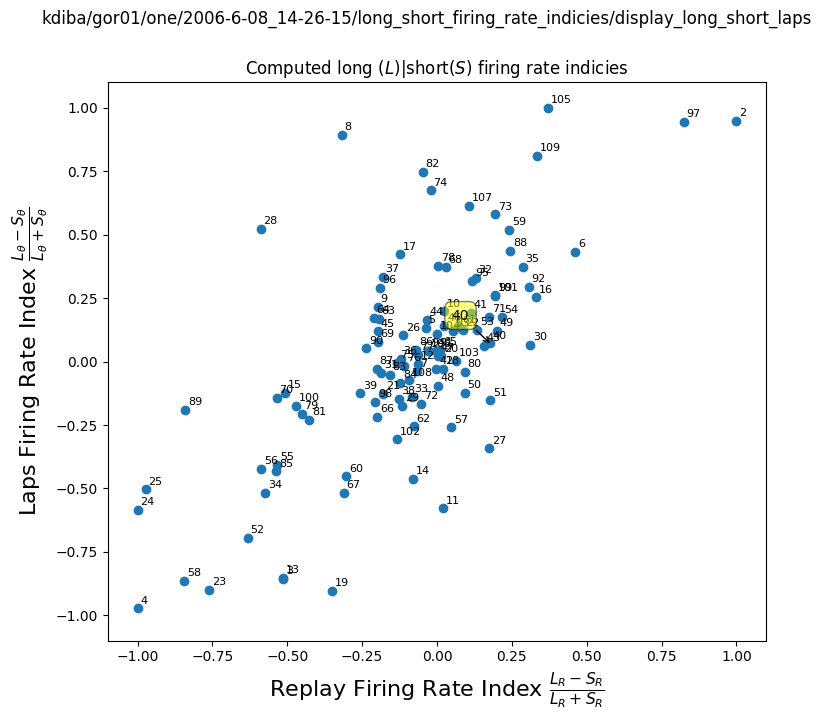

In [7]:
fig = _out.figures
fig


# 2023-05-19 - Testing S-only emergence, L-only replays in S, peak position remappings 

In [ ]:
""" 24 cells, 133 Epochs, 789 Total Timebins
# Other
	
	- is_non_firing_time_bin: numpy.ndarray - (24, 789)
	- all_epochs_num_epoch_time_bins: numpy.ndarray - (133,)
	
    ## Indexing Helpers:
		- all_epochs_reverse_flat_epoch_indicies_array: numpy.ndarray - (789,)
		- split_by_epoch_reverse_flattened_time_bin_indicies: list - (133,)
    
	- original_1D_decoder: pyphoplacecellanalysis.Analysis.Decoder.reconstruction.BasePositionDecoder
		- pf: neuropy.analyses.placefields.PfND
		- neuron_IDXs: numpy.ndarray - (24,)
		- neuron_IDs: numpy.ndarray - (24,)
		- F: numpy.ndarray - (119, 24)
		- P_x: numpy.ndarray - (119, 1)
        
	- flat_all_epochs_decoded_epoch_time_bins: numpy.ndarray - (24, 789)

# Measured
	- flat_all_epochs_measured_cell_spike_counts: numpy.ndarray - (24, 789)
	- flat_all_epochs_measured_cell_firing_rates: numpy.ndarray - (24, 789)


# Expected
	- flat_all_epochs_computed_expected_cell_firing_rates: numpy.ndarray - (24, 789)
	- flat_all_epochs_difference_from_expected_cell_spike_counts: numpy.ndarray - (24, 789)
	- flat_all_epochs_difference_from_expected_cell_firing_rates: numpy.ndarray - (24, 789)
    
    
    
## Epoch-based
	- all_epochs_decoded_epoch_time_bins_mean: numpy.ndarray - (133, 24)

    
    
    
- flat_all_epochs_measured_cell_firing_rates: numpy.ndarray - .shape: (24, 789) 
- flat_all_epochs_computed_expected_cell_firing_rates: numpy.ndarray - .shape: (24, 789)


"""

# 2023-04-13 - Find Good looking epochs:

In [ ]:
import matplotlib.pyplot as plt
%matplotlib qt
import matplotlib.patheffects as path_effects

from pyphoplacecellanalysis.Pho2D.stacked_epoch_slices import DecodedEpochSlicesPaginatedFigureController
from pyphoplacecellanalysis.Analysis.Decoder.reconstruction import DecodedFilterEpochsResult
from pyphoplacecellanalysis.Analysis.Decoder.decoder_result import LeaveOneOutDecodingAnalysisResult


In [ ]:
_out_pagination_controller_L = DecodedEpochSlicesPaginatedFigureController.init_from_decoder_data(long_results_obj.active_filter_epochs, long_results_obj.all_included_filter_epochs_decoder_result, included_epoch_indicies=good_epoch_indicies_L, 
	xbin=long_results_obj.original_1D_decoder.xbin, global_pos_df=global_session.position.df, a_name='Long SubsetEpochs', active_context=long_epoch_context,  max_subplots_per_page=200) # 10

In [ ]:
_out_pagination_controller_S = DecodedEpochSlicesPaginatedFigureController.init_from_decoder_data(short_results_obj.active_filter_epochs, short_results_obj.all_included_filter_epochs_decoder_result, included_epoch_indicies=good_epoch_indicies_S, 
	xbin=short_results_obj.original_1D_decoder.xbin, global_pos_df=global_session.position.df, a_name='Short SubsetEpochs', active_context=short_epoch_context,  max_subplots_per_page=200) # 10

In [ ]:
_out = curr_active_pipeline.display('_display_long_and_short_stacked_epoch_slices')


In [ ]:
## Getting selections out of DecoedEpochSlicesPaginationController
curr_active_pipeline.display_output_history_list
# Ideally could search like: '_display_long_and_short_stacked_epoch_slices'
active_result_backup = curr_active_pipeline.last_added_display_output

In [ ]:
list(active_result_backup.keys()) # ['name', 'context', 'figures', 'axes', 'plot_data']

active_result_backup['context'] # (IdentifyingContext<('kdiba', 'gor01', 'one', '2006-6-08_14-26-15', 'DecodedEpochSlices', 'replays', 'long_results_obj')>,
								#  IdentifyingContext<('kdiba', 'gor01', 'one', '2006-6-08_14-26-15', 'DecodedEpochSlices', 'replays', 'short_results_obj')>)

pagination_controllers = active_result_backup.plot_data['controllers']
long_controller = pagination_controllers[0]
short_controller = pagination_controllers[1]

In [ ]:
long_controller.selected_indicies # np.array([ 13,  14,  15,  25,  27,  28,  31,  37,  42,  45,  48,  57,  61,  62,  63,  76,  79,  82,  89,  90, 111, 112, 113, 115])

# np.array([5,  13,  15,  17,  20,  21,  24,  31,  33,  43,  44,  49,  63, 64,  66,  68,  70,  71,  74,  76,  77,  78,  84,  90,  94,  95, 104, 105, 122, 123])

In [ ]:
short_controller.selected_indicies # np.array([  9,  11,  13,  14,  15,  20,  22,  25,  37,  40,  45,  48,  61, 62,  76,  79,  84,  89,  90,  93,  94, 111, 112, 113, 115, 121])

# np.array([ 12,  13,  15,  17,  20,  24,  30,  31,  32,  33,  41,  43,  49, 54,  55,  68,  70,  71,  73,  76,  77,  78,  84,  89,  94, 100, 104, 105, 111, 114, 115, 117, 118, 122, 123, 131])

In [ ]:
final_context_L = curr_active_pipeline.build_display_context_for_session(display_fn_name='DecodedEpochSlices', epochs='replays', decoder='long_results_obj')
final_context_S = curr_active_pipeline.build_display_context_for_session(display_fn_name='DecodedEpochSlices', epochs='replays', decoder='short_results_obj')
# _out_pagination_controller.params.active_identifying_figure_ctx.adding_context(None,  user_annotation="selections")
selections_context_L = final_context_L.adding_context(None,  user_annotation="selections")
selections_context_S = final_context_S.adding_context(None,  user_annotation="selections")

# IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='two',session_name='2006-6-07_16-40-19',display_fn_name='DecodedEpochSlices',epochs='replays',decoder='long_results_obj',user_annotation='selections')
# IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='two',session_name='2006-6-07_16-40-19',display_fn_name='DecodedEpochSlices',epochs='replays',decoder='short_results_obj')

In [ ]:
# Update the `long_results_obj.active_filter_epochs` and `short_results_obj.active_filter_epochs` objects with the selection information
assert long_controller.is_selected.shape[0] == long_results_obj.active_filter_epochs.n_epochs
assert short_controller.is_selected.shape[0] == short_results_obj.active_filter_epochs.n_epochs
# for some reason the active_filter_epochs on both the long and the short objects contain properties about the other one as well, so keep with tradition and add them to both as well
long_results_obj.active_filter_epochs._df['long_is_user_included'] = long_controller.is_selected
long_results_obj.active_filter_epochs._df['short_is_user_included'] = short_controller.is_selected
short_results_obj.active_filter_epochs._df['long_is_user_included'] = long_controller.is_selected
short_results_obj.active_filter_epochs._df['short_is_user_included'] = short_controller.is_selected

In [ ]:
print(list(long_controller.params.keys())) # ['name', 'window_title', 'num_slices', '_debug_test_max_num_slices', 'active_num_slices', 'global_epoch_start_t', 'global_epoch_end_t', 'single_plot_fixed_height', 'all_plots_height', 'epoch_labels', 'variable_name', 'xbin', 'enable_flat_line_drawing', 'debug_print', 'active_identifying_figure_ctx', 'flat_all_data_indicies', 'is_selected', 'callback_id', 'on_render_page_callbacks']

# TODO 2023-06-19 14:31: - [ ] Come up with system for storing user-annotations:
 Need to store user-annotations and labeled selections for Epochs:

	date_annotated: datetime - the date the annotations were made
	annotation_author: str - the person who made the annotations
	annotation_content: Any - the content of the annotation



In [ ]:
from PendingNotebookCode import UserAnnotationsManager

# Get the manual user annotations to determine the good replays for both long/short decoding:
user_annotations = UserAnnotationsManager.get_user_annotations()

final_context_L = curr_active_pipeline.build_display_context_for_session(display_fn_name='DecodedEpochSlices', epochs='replays', decoder='long_results_obj')
final_context_S = curr_active_pipeline.build_display_context_for_session(display_fn_name='DecodedEpochSlices', epochs='replays', decoder='short_results_obj')
# _out_pagination_controller.params.active_identifying_figure_ctx.adding_context(None,  user_annotation="selections")
selections_context_L = final_context_L.adding_context(None,  user_annotation="selections")
selections_context_S = final_context_S.adding_context(None,  user_annotation="selections")

## try to get the user annotations for this session:
selection_idxs_L = user_annotations[selections_context_L]
selection_idxs_S = user_annotations[selections_context_S]

selection_idxs_L

In [ ]:
selection_idxs_S

In [ ]:
# For updating the controller from the selected indicies:
for a_selected_index in selection_idxs_L:
	_out_pagination_controller.params.is_selected[a_selected_index] = True

_out_pagination_controller.perform_update_selections(defer_render=False)

# Other Programmatic Figures

In [ ]:
curr_active_pipeline.reload_default_display_functions()

In [ ]:
from pyphoplacecellanalysis.General.Mixins.CrossComputationComparisonHelpers import _find_any_context_neurons

## Builds proper sort indicies for '_display_short_long_pf1D_comparison'
long_ratemap = long_pf1D.ratemap
short_ratemap = short_pf1D.ratemap

curr_any_context_neurons = _find_any_context_neurons(*[k.neuron_ids for k in [long_ratemap, short_ratemap]])
curr_any_context_neurons

In [ ]:
from neuropy.plotting.ratemaps import plot_ratemap_1D
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.MultiContextComparingDisplayFunctions.LongShortTrackComparingDisplayFunctions import plot_short_v_long_pf1D_comparison, LongShortTrackComparingDisplayFunctions

curr_active_pipeline.reload_default_display_functions()

%matplotlib qt
active_identifying_session_ctx = curr_active_pipeline.sess.get_context() # 'bapun_RatN_Day4_2019-10-15_11-30-06'

long_single_cell_pfmap_processing_fn = None
short_single_cell_pfmap_processing_fn = None
# sort_idx = None
# sort_idx = sort_ind
# sort_idx = sort_indicies
# sort_idx = new_all_aclus_sort_indicies
sort_idx = 'peak_long'
# sort_idx = 'bad'

# out = curr_active_pipeline.display('_display_short_long_pf1D_comparison', active_identifying_session_ctx, single_figure=False, debug_print=True, fignum='Short v Long pf1D Comparison',
#                                    long_kwargs={'included_unit_neuron_IDs': curr_any_context_neurons, 'included_unit_indicies': None, 'sortby': sort_idx, 'single_cell_pfmap_processing_fn': long_single_cell_pfmap_processing_fn},
#                                    short_kwargs={'included_unit_neuron_IDs': curr_any_context_neurons, 'included_unit_indicies': None,'sortby': sort_idx, 'single_cell_pfmap_processing_fn': short_single_cell_pfmap_processing_fn, 'curve_hatch_style': {'hatch':'///', 'edgecolor':'k'}},
#                                   )

out = curr_active_pipeline.display('_display_short_long_pf1D_comparison', active_identifying_session_ctx, single_figure=False, debug_print=False, fignum='Short v Long pf1D Comparison',
                                   long_kwargs={'sortby': sort_idx, 'single_cell_pfmap_processing_fn': long_single_cell_pfmap_processing_fn},
                                   short_kwargs={'sortby': sort_idx, 'single_cell_pfmap_processing_fn': short_single_cell_pfmap_processing_fn, 'curve_hatch_style': {'hatch':'///', 'edgecolor':'k'}},
                                  )
                                  

# ax = out.axes[0]

In [ ]:
import matplotlib.pyplot as plt
plt.show()

In [ ]:
curr_active_pipeline.display('_display_short_long_pf1D_comparison', single_figure=True)

# 2023-06-01 - Testing new metrics:

In [ ]:

curr_long_short_post_decoding = curr_active_pipeline.global_computation_results.computed_data['long_short_post_decoding']
## Extract variables from results object:
expected_v_observed_result, curr_long_short_rr = curr_long_short_post_decoding.expected_v_observed_result, curr_long_short_post_decoding.rate_remapping
rate_remapping_df, high_remapping_cells_only = curr_long_short_rr.rr_df, curr_long_short_rr.high_only_rr_df
Flat_epoch_time_bins_mean, Flat_decoder_time_bin_centers, num_neurons, num_timebins_in_epoch, num_total_flat_timebins, is_short_track_epoch, is_long_track_epoch, short_short_diff, long_long_diff = expected_v_observed_result['Flat_epoch_time_bins_mean'], expected_v_observed_result['Flat_decoder_time_bin_centers'], expected_v_observed_result['num_neurons'], expected_v_observed_result['num_timebins_in_epoch'], expected_v_observed_result['num_total_flat_timebins'], expected_v_observed_result['is_short_track_epoch'], expected_v_observed_result['is_long_track_epoch'], expected_v_observed_result['short_short_diff'], expected_v_observed_result['long_long_diff']

print(f'long_test: {np.mean(long_long_diff)}')
print(f'short_test: {np.mean(short_short_diff)}')

In [ ]:
# long_results_obj.original_1D_decoder
replay_result_df = deepcopy(long_results_obj.active_filter_epochs.to_dataframe())
replay_result_df

In [ ]:
short_results_obj.active_filter_epochs.to_dataframe()

In [ ]:
# Look at lap speed over time - doesn't look like there's a difference between the long and the short track speeds
global_session.position.compute_higher_order_derivatives()
running_pos_df = global_session.position.to_dataframe()
ax = running_pos_df.plot(x='t', y=['lin_pos','speed'], title='Running Speed over Time')
ax

In [ ]:
# Call the function
fig, ax = plot_lines(replay_result_df)